## Detect Cyber Intrusion Using Machine Learning

### Task 1: Import Libraries and Modules

In [30]:
import sklearn.metrics
import sklearn.model_selection
import time
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import sklearn.ensemble
import sklearn.tree 
import sklearn.linear_model 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score


### Task 2: Preprocess the Dataset

#### Load CSV file into a DataFrame

In [5]:
data_frame = df = pd.read_csv('/usercode/SIMARGL2021.csv')

#### Display the first few rows of the CSV file


In [6]:
data_frame.head()


,BIFLOW_DIRECTION,DIRECTION,DST_TO_SRC_SECOND_BYTES,FIREWALL_EVENT,FIRST_SWITCHED,FLOW_ACTIVE_TIMEOUT,FLOW_DURATION_MICROSECONDS,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_END_SEC,...,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,L7_PROTO_NAME,SAMPLING_INTERVAL,TOTAL_FLOWS_EXP,LABEL
0,1,0,138,0,1622174400,120,682,0,1.622170e+12,1622174400,...,0,0,0,0,0,0,DNS,1,1365973,Normal flow
1,1,0,75,0,1622174400,120,579,0,1.622170e+12,1622174400,...,0,0,0,0,0,0,DNS,1,1365974,Normal flow
2,1,0,40,0,1622174400,120,213,0,1.622170e+12,1622174400,...,0,0,0,0,40,40,Unknown,1,1365976,Normal flow
3,1,0,166,0,1622174400,120,257,0,1.622170e+12,1622174400,...,0,0,0,0,0,0,DNS,1,1365978,Normal flow
4,1,0,",",0,1622174400,120,0,0,1.622170e+12,1622174400,...,0,0,0,0,196,0,ICMP,1,1365979,Normal flow


#### Select the 15 features

In [7]:
selected_columns = [
'DST_TOS', 'SRC_TOS', 'TCP_WIN_SCALE_OUT', 'TCP_WIN_SCALE_IN', 'TCP_FLAGS','TCP_WIN_MAX_OUT', 'PROTOCOL', 'TCP_WIN_MIN_OUT', 'TCP_WIN_MIN_IN','TCP_WIN_MAX_IN', 'LAST_SWITCHED', 'TCP_WIN_MSS_IN', 'TOTAL_FLOWS_EXP','FIRST_SWITCHED', 'FLOW_DURATION_MILLISECONDS', 'LABEL'
]
data_frame = data_frame[selected_columns]
data_frame.head()

,DST_TOS,SRC_TOS,TCP_WIN_SCALE_OUT,TCP_WIN_SCALE_IN,TCP_FLAGS,TCP_WIN_MAX_OUT,PROTOCOL,TCP_WIN_MIN_OUT,TCP_WIN_MIN_IN,TCP_WIN_MAX_IN,LAST_SWITCHED,TCP_WIN_MSS_IN,TOTAL_FLOWS_EXP,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,LABEL
0,0,0,0,0,0,0,17,0,0,0,1622174400,0,1365973,1622174400,0,Normal flow
1,0,0,0,0,0,0,17,0,0,0,1622174400,0,1365974,1622174400,0,Normal flow
2,40,40,0,0,22,0,6,0,1024,1024,1622174400,0,1365976,1622174400,0,Normal flow
3,0,0,0,0,0,0,17,0,0,0,1622174400,0,1365978,1622174400,0,Normal flow
4,0,196,0,0,0,0,1,0,0,0,1622174400,0,1365979,1622174400,0,Normal flow


#### Remove duplicate rows

In [8]:
data_frame.drop_duplicates(inplace=True)

/tmp/ipykernel_175/1689651136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.drop_duplicates(inplace=True)


### Task 3: Explore the Dataset

#### Display each label and its count via a bar graph


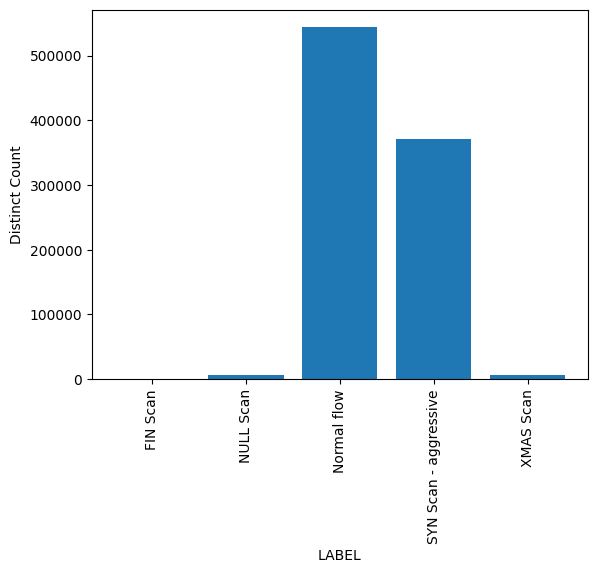

In [9]:
grouped_data = data_frame.groupby('LABEL').size()
fig, ax = plt.subplots(1)
ax.bar(grouped_data.index, grouped_data.values)
ax.set(xlabel='LABEL', ylabel='Distinct Count')
plt.xticks(rotation=90)
plt.show()

#### Plot the distinct counts

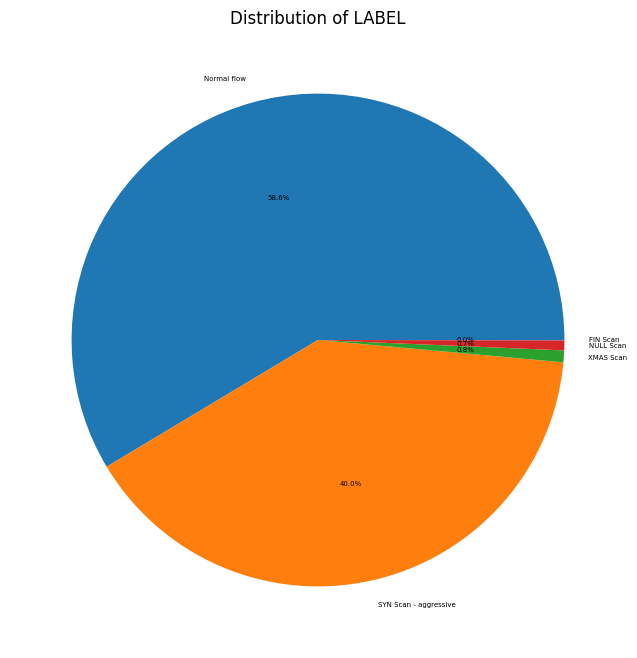

In [10]:
grouped_data = data_frame['LABEL'].value_counts()
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(grouped_data.values, labels=grouped_data.index, autopct='%1.1f%%', textprops={'fontsize': 5})
ax.set_title('Distribution of LABEL')
plt.show()

### Task 4: Standardize and Encode the Data

#### Create a copy of the data

In [11]:
normalized_data = data_frame.copy()
numerical_columns = normalized_data.select_dtypes(include=['float64', 'int64']).columns

#### Extract the numerical columns to be normalized

In [12]:
non_numerical_columns = normalized_data.select_dtypes(exclude=['float64', 'int64']).columns


#### Extract the non-numerical columns to be label encoded

In [13]:
label_encoder = LabelEncoder()
normalized_data[non_numerical_columns] = normalized_data[non_numerical_columns].apply(label_encoder.fit_transform)

#### Standardize the numerical columns

In [14]:
scaler = StandardScaler() 
normalized_data[numerical_columns] = scaler.fit_transform(normalized_data[numerical_columns])

In [15]:
normalized_data.head()

,DST_TOS,SRC_TOS,TCP_WIN_SCALE_OUT,TCP_WIN_SCALE_IN,TCP_FLAGS,TCP_WIN_MAX_OUT,PROTOCOL,TCP_WIN_MIN_OUT,TCP_WIN_MIN_IN,TCP_WIN_MAX_IN,LAST_SWITCHED,TCP_WIN_MSS_IN,TOTAL_FLOWS_EXP,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,LABEL
0,-0.202520,-0.275953,-0.304294,-0.340399,-1.094170,-0.296931,1.602891,-0.296429,-0.373770,-0.377188,0.798357,-1.065921,-0.822983,0.798359,-0.199755,2
1,-0.202520,-0.275953,-0.304294,-0.340399,-1.094170,-0.296931,1.602891,-0.296429,-0.373770,-0.377188,0.798357,-1.065921,-0.822982,0.798359,-0.199755,2
2,1.521307,0.913199,-0.304294,-0.340399,0.773889,-0.296931,-0.512673,-0.296429,-0.312306,-0.316160,0.798357,-1.065921,-0.822981,0.798359,-0.199755,2
3,-0.202520,-0.275953,-0.304294,-0.340399,-1.094170,-0.296931,1.602891,-0.296429,-0.373770,-0.377188,0.798357,-1.065921,-0.822980,0.798359,-0.199755,2
4,-0.202520,5.550894,-0.304294,-0.340399,-1.094170,-0.296931,-1.474293,-0.296429,-0.373770,-0.377188,0.798357,-1.065921,-0.822979,0.798359,-0.199755,2


### Task 5: Separate Labels and Split Data into Train and Test Subsets

#### Separate data and labels

In [16]:
X = normalized_data.drop(columns=['LABEL'],axis=1)

Y = normalized_data['LABEL']

#### Split data into train and test subsets


In [20]:
X_train, X_test, y_train, y_test = train_test_split (X, Y, test_size=0.3, random_state=42)



### Task 6: Train Random Forest

#### Create a random forest classifier

In [21]:
rf_classifier = RandomForestClassifier(n_estimators=30)

#### Measure the training time

In [22]:
start_time = time.time() 
rf_classifier.fit(X_train, y_train)
end_time = time.time()
training_timeRFC = end_time - start_time

### Task 7: Test Random Forest

#### Make predictions on the test set


In [23]:
y_pred = rf_classifier.predict(X_test)


#### Calculate and print the accuracy, F1 score, precision, and recall

In [31]:
accuracyRFC = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted') 
precision = precision_score(y_test, y_pred,average='weighted')  
recall = recall_score(y_test, y_pred, average='weighted')
print("Training time:", training_timeRFC)
print("Accuracy:", accuracyRFC)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Training time: 15.744781255722046
Accuracy: 0.998624044375467
F1 Score: 0.998630157182019
Precision: 0.9986374265737917
Recall: 0.998624044375467


### Task 8: Train Decision Tree

#### Create a DecisionTreeClassifier with criterion='entropy' and max_depth=4

In [32]:
dt_classifier = DecisionTreeClassifier(criterion='entropy',max_depth=4)

#### Measure the training time


In [33]:
start_time = time.time()
dt_classifier.fit(X_train, y_train)
end_time = time.time()
training_timeDT = end_time - start_time

### Task 9: Test Decision Tree

#### Make predictions on the test set

In [34]:
y_pred = dt_classifier.predict(X_test)

#### Calculate and print the accuracy, F1 score, precision, and recall

In [35]:
accuracyDT = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Training time:", training_timeDT)
print("Accuracy:", accuracyDT)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Training time: 1.8000807762145996
Accuracy: 0.9955056906363166
F1 Score: 0.995816927472435
Precision: 0.9966325907822287
Recall: 0.9955056906363166


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Task 10: Train Naive Bayes

#### Create a Gaussian Naive Bayes classifier

In [36]:
nb_classifier = GaussianNB()

#### Measure the training time

In [37]:
start_time = time.time()
nb_classifier.fit(X_train, y_train)
end_time = time.time()
training_timeNB = end_time - start_time

### Task 11: Test Naive Bayes

#### Make predictions on the test dataset

In [38]:
y_pred = nb_classifier.predict(X_test)

#### Calculate and print the accuracy, F1 sore, precision, and recall

In [39]:
accuracyNB = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, 
average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("Training time:", training_timeNB)
print("Accuracy:", accuracyNB)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Training time: 0.21271109580993652
Accuracy: 0.9912089728114043
F1 Score: 0.9923627270670682
Precision: 0.9948001931044119
Recall: 0.9912089728114043


### Task 12: Compare the Accuracy and Training Times

#### Accuracy scores and training time of the three algorithms

In [40]:
accuracy_scores = [accuracyRFC, accuracyDT, accuracyNB]
train_times = [training_timeRFC, training_timeDT, training_timeNB]

#### Names of the algorithms

In [41]:
algorithm_names = ['Random Forest', 'Decision Tree', 'Gaussian Naive Bayes']

#### Create a bar plot for accuracy

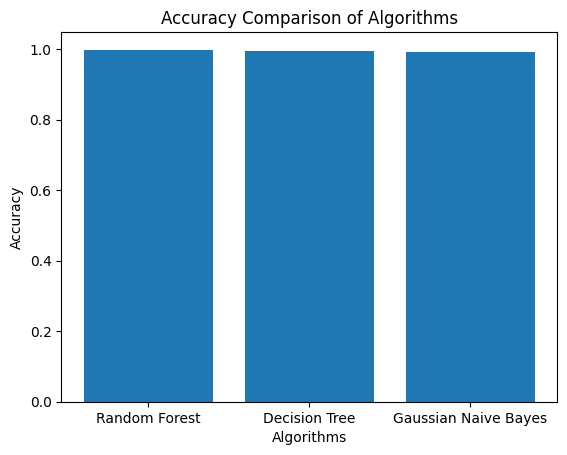

In [42]:
plt.bar(algorithm_names, accuracy_scores)
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Algorithms')
plt.show()

#### Create a bar plot for training time

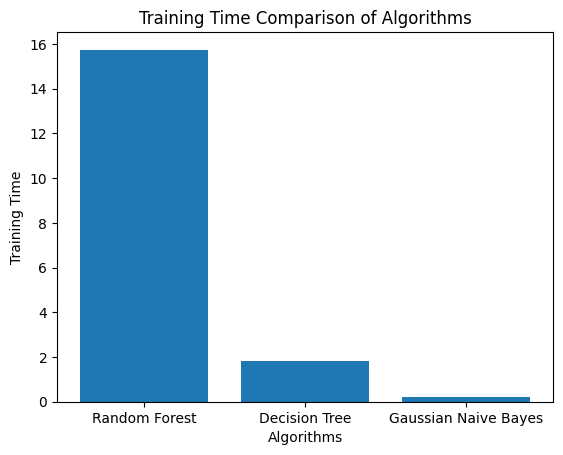

In [43]:
plt.bar(algorithm_names, train_times)
plt.xlabel('Algorithms')
plt.ylabel('Training Time')
plt.title('Training Time Comparison of Algorithms')
plt.show()